In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.interpolate import splrep, splev
import datetime as dt
import matplotlib.pyplot as plt
from fbprophet import Prophet
%matplotlib inline
plt.rcParams.update({'font.size': 18})

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
def smape(satellite_predicted_values, satellite_true_values):
    # the division, addition and subtraction are pointwise
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values)/
                (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))


def drop_close(t, x, eps=10**9):
    '''
    t = time array, x = data array, eps is in nanoseconds
    Returns entries in t,x with corresponding consecutive times > eps
    
    '''
    t = np.array(t) #if not already np array, convert
    x = np.array(x) #if t or x are pandas Series, will have dimension mismatch
    far = np.concatenate([(t[1:] - t[:-1]) > eps, [True]])
    return t[far], x[far]


def resample(t, x, step=10 * 10**9, t_new=None, return_t=False):
    '''
    t: time array (or series); 
    x: data array (or series); 
    t_new: new time scale from start to end of t with step size step;
    step: = 10 seconds by default; 
    return_t: by default, do not return resampled times
    
    resample time series or array by 10 (default) sec intervals and 
    return new time series (if t_new=True) and spline approximation series for data
    
    
    '''
    t, x = drop_close(t, x)
    if t_new is None:
        t_new = np.arange(t[0], t[-1], step)
    try:
        spl = splrep(t, x)
        x_new = splev(t_new, spl)
    except:
        raise ValueError(f'interpolation error, x length = {len(x)}, \
        t_new length = {len(t_new)}')

    return (t_new, x_new) if return_t else x_new


def get_peaks(array):
    '''
    returns index of "sharp" peaks, excluding first and last values of array
    
    index of "smooth peaks", e.g. 1 2 3 9 9 3 2 1, is not returned
    '''
    return np.where((array[1:-1] > array[2:]) & (array[1:-1] > array[:-2]))[0] + 1


def get_satellite_data(data, sat_id):
    '''
    returns all data for particular satellite by id
    '''
    return data[data['sat_id'] == sat_id].reset_index(drop=True)


def remove_time_jumps(satellite_data, features_list=('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                      suffix='_jumps_removed',time_threshold = 0.00003):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    '''
    satellite_data['t'] = ((pd.to_datetime(satellite_data['epoch']) - pd.to_datetime(satellite_data['epoch'])[0]) /
                           np.timedelta64(1, 'D')).astype(float)
    satellite_data['dt'] = satellite_data['t'].diff()
    # the most frequent time interval
    t_standard = satellite_data['dt'].value_counts().index[0]

    # time steps used for simulations
    satellite_data['t_sim'] = satellite_data.index.values * t_standard

    n = satellite_data.shape[0]
    corrected_features = []
    for feature_name in features_list:
        corrected_feature = [0] * n
        corrected_feature[0] = satellite_data[feature_name][0]

        feature = satellite_data[feature_name]

        for j in range(1, n - 1):
            if satellite_data.t[j] < satellite_data.t_sim[j] - time_threshold:
                # approximate by the left side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] < satellite_data.t_sim[j - step] - time_threshold:
                    step += 1
                #             print(step)
                corrected_feature[j] = feature[j - step] - (satellite_data.t_sim[j - step] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j - step] - satellite_data.t_sim[j - step - 1]) * (
                                              feature[j - step] - feature[j - step - 1])
            elif satellite_data.t[j] > satellite_data.t_sim[j] + time_threshold:
                # approximate by the right side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] > satellite_data.t_sim[j + step] + time_threshold:
                    step += 1
    
                corrected_feature[j] = feature[j + step + 1] - (satellite_data.t_sim[j + step + 1] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j + step + 1] - satellite_data.t_sim[j + step]) * (
                                              feature[j + step + 1] - feature[j + step])
            else:
                corrected_feature[j] = feature[j]
    
        corrected_feature[n - 1] = feature[n - 1] + corrected_feature[n - 2] - feature[n - 2]
        corrected_features.append(corrected_feature)
    return pd.DataFrame(corrected_features, index=[f + suffix for f in features_list]).T

In [3]:
def insert_previous_and_shift(df,col_name,ind):
    '''
    input a data frame (df), column name (col_name), and index (ind)
    insert previous value of df[col_name] at index and shift the rest 
    of df[col_name] from ind by +1;
    This is used for remove_time_jumps_fast
    '''
    shifted_series = df[col_name].shift(1)
    df[col_name].iloc[ind] = df[col_name].iloc[ind-1]
    df[col_name].iloc[ind+1:] = shifted_series.iloc[ind+1:]
    return df

In [4]:
def remove_time_jumps_fast(data, features_list=
                           ('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                           threshold = 0.000001):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    s_data = satellite data
    the features are replaced by the correction
    note that threshold here is not the same as in remove_time_jumps
    '''
    data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                               np.timedelta64(1, 'D')).astype(float)
    data['dt'] = data['t'].diff(1)

    index_for_correction = data[data['dt'] < threshold].index 
    #print(index_for_correction)
    if list(index_for_correction): #if non empty
        for feature in features_list:
            for i in index_for_correction:
                data = insert_previous_and_shift(data,feature,i)
    return data

## Transforming all the data

In [6]:
import utils
from LinearAlignment import LinearAlignment

In [7]:
features_list=['x', 'y', 'z', 'Vx', 'Vy', 'Vz']

In [8]:
data = pd.read_csv('data/train.csv')
data['time'] = data['epoch']
data['epoch'] = pd.to_datetime(data['epoch']).values.astype(float)
data.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,time
0,0,1.388534e+18,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,2014-01-01T00:00:00.000
1,1,1.388537e+18,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,2014-01-01T00:46:43.000
2,2,1.388540e+18,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,2014-01-01T01:33:26.001
3,3,1.388543e+18,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,2014-01-01T02:20:09.001
4,4,1.388546e+18,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,2014-01-01T03:06:52.002


In [9]:
result_df = []
alignment_model = LinearAlignment()

satellites_list = data['sat_id'].unique()

transf_df = pd.DataFrame([])
for sat_id in tqdm(satellites_list):
    
#     sat_data = utils.get_satellite_data(data, sat_id)
    try:
        sat_data = remove_time_jumps_fast(get_satellite_data(data, sat_id))
#         sat_data = get_satellite_data(data, sat_id) # run to check the smape score before any transformations
    except KeyError as e:
        print(f'jump removal failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue

    n_train = len(sat_data) // 2
    train_sat_data = sat_data[:n_train]
    
    pred = pd.DataFrame(index = sat_data.index)
    pred['epoch'] = sat_data['epoch']
    pred['t'] = sat_data['t']
    pred['sat_id'] = sat_id
    
    try:

        for feature_name in features_list:
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x=-train_sat_data[f'{feature_name}_sim'].values,
                                gt=-train_sat_data[feature_name].values)
            option1 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x= train_sat_data[f'{feature_name}_sim'].values,
                                gt= train_sat_data[feature_name].values)
            
            option2 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            
            if utils.smape(option1,sat_data[feature_name].values) < utils.smape(option2,sat_data[feature_name].values):
                pred[f'{feature_name}_sim']  = option1
            else:
                pred[f'{feature_name}_sim']  = option2
                
            pred[feature_name]=sat_data[feature_name]
        
                  
            
    except Exception as e:
        print(f'linear alignment failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
    
    transf_df = transf_df.append(pred)

  0%|                                                                                          | 0/600 [00:00<?, ?it/s]C:\Users\Tatiana\Anaconda3\envs\idao\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
 42%|█████████████████████████████████▌                                              | 252/600 [01:03<01:35,  3.64it/s]C:\Users\Tatiana\Documents\GitHub\IDAO-2020\LinearAlignment.py:39: RuntimeWarning: invalid value encountered in double_scalars
  t[peaks_x[common_peaks_count - 1]] - t[peaks_x[0]])
C:\Users\Tatiana\Documents\GitHub\IDAO-2020\utils.py:30: RuntimeWarning: invalid value encountered in greater
  far = np.concatenate([(t[1:] - t[:-1]) > eps, [True]])


linear alignment failed for satellite 252:	ValueError interpolation error, x length = 1,         t_new length = 94


 50%|████████████████████████████████████████▏                                       | 301/600 [01:17<01:32,  3.24it/s]

linear alignment failed for satellite 301:	ValueError interpolation error, x length = 1,         t_new length = 99


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:56<00:00,  2.84it/s]


In [10]:
transf_df.head()

,epoch,t,sat_id,x_sim,x,y_sim,y,z_sim,z,Vx_sim,Vx,Vy_sim,Vy,Vz_sim,Vz
0,1.388534e+18,0.000000,0,-8843.131454,-8855.823863,13138.221690,13117.780146,-20741.615306,-20728.353233,-0.907527,-0.908303,-3.804930,-3.808436,-2.024133,-2.022083
1,1.388537e+18,0.032442,0,-10555.383233,-10567.672384,1650.877354,1619.746066,-24472.866315,-24451.813271,-0.303785,-0.302590,-4.269805,-4.272617,-0.616657,-0.612796
2,1.388540e+18,0.064884,0,-10572.073071,-10578.684043,-10142.921171,-10180.467460,-24271.700511,-24238.280949,0.274743,0.277435,-4.046918,-4.047522,0.718453,0.723155
3,1.388543e+18,0.097326,0,-9150.464665,-9148.251857,-20614.425346,-20651.437460,-20766.941498,-20720.381279,0.712296,0.715600,-3.375521,-3.373762,1.717987,1.722115
4,1.388546e+18,0.129769,0,-6730.920362,-6719.092336,-28898.508792,-28929.061629,-14995.891684,-14938.907967,0.989274,0.992507,-2.523086,-2.519732,2.341996,2.344703


In [11]:
transf_df.shape

(649719, 15)

In [12]:
# for now, simply append non-transformed values fot the satellites 252
transf_df = transf_df.append(remove_time_jumps_fast(get_satellite_data(data, 252))[transf_df.columns])
transf_df = transf_df.append(remove_time_jumps_fast(get_satellite_data(data, 301))[transf_df.columns])
transf_df.shape

(649912, 15)

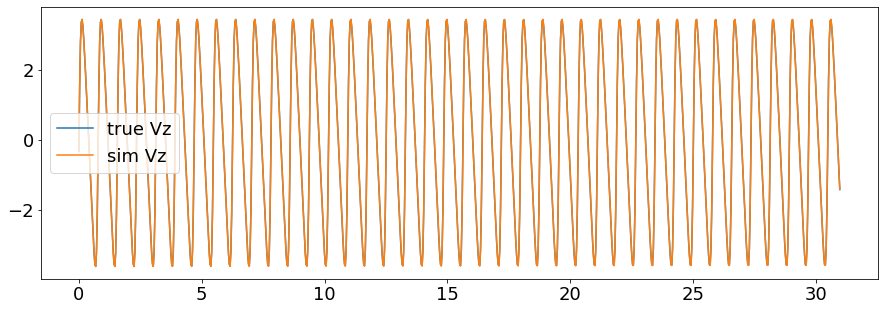

In [14]:
m_data = transf_df[transf_df.sat_id == 157]
plt.figure(figsize=(15, 5))
plt.plot(m_data['t'],m_data['Vx'], label = 'true Vz')
# plt.plot(m_data['t'],0*m_data['t']+ m_data['Vx_sim'], label = 'sim lifted Vz')
plt.plot(m_data['t'],m_data['Vx_sim'], label = 'sim Vz')
# plt.xlim([28,30])

plt.legend()

## Prophet modeling

In [15]:
# I am using this temporarily to estimate period in days (as a distance bbetween peaks)
m_data[-m_data['Vx_sim'] + max(m_data['Vx_sim']) <0.01]['t']

4       0.130292
28      0.912041
52      1.693790
76      2.475539
100     3.257288
124     4.039037
148     4.820786
172     5.602535
196     6.384284
220     7.166034
244     7.947783
268     8.729532
292     9.511281
316    10.293030
340    11.074779
364    11.856528
388    12.638277
412    13.420026
436    14.201776
460    14.983525
484    15.765274
508    16.547023
532    17.328772
556    18.110521
580    18.892270
604    19.674019
628    20.455768
652    21.237517
676    22.019267
700    22.801016
724    23.582765
748    24.364514
772    25.146263
796    25.928012
820    26.709761
844    27.491510
868    28.273260
892    29.055009
916    29.836758
940    30.618507
Name: t, dtype: float64

In [16]:
# create the time series data frome for prophet from our data
ts = pd.DataFrame([])

ts['ds'] = pd.to_datetime(m_data['epoch'])
ts['y'] = m_data['Vx']-m_data['Vx_sim']

In [17]:
ts.head()

,ds,y
0,2014-01-01 00:00:00.000000000,-0.007770
1,2014-01-01 00:46:54.296999936,0.000586
2,2014-01-01 01:33:48.593999872,0.005457
3,2014-01-01 02:20:42.889999872,0.005365
4,2014-01-01 03:07:37.187000064,0.003198


In [18]:
ts.shape

(952, 2)

In [24]:
m = Prophet(changepoint_prior_scale=0.01,
            weekly_seasonality = False,
            yearly_seasonality = False)
# m.add_seasonality(name='monthly', period=31, fourier_order=10)
m.add_seasonality(name='grid', period = 0.782, fourier_order=50) # put here the estimated period in days from 4 cells above
m.add_seasonality(name='grid2', period = 260*0.782, fourier_order=10)
# m.add_seasonality(name='grid5', period = 0.786326*15, fourier_order=10)

In [25]:
# fit model using 70% of the data
n = 2*len(ts)//3
m.fit(ts[:n])

In [28]:
# create the data frame for prediction
future =ts[n:] [['ds']]
# m.make_future_dataframe(freq = 'H', periods=16*24)
future.tail()

,ds
947,2014-01-31 20:18:59.067000064
948,2014-01-31 21:05:53.364000000
949,2014-01-31 21:52:47.660999936
950,2014-01-31 22:39:41.958000128
951,2014-01-31 23:26:36.254000128


In [29]:
ts.shape

(952, 2)

In [30]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
313,2014-01-31 20:18:59.067000064,-0.005993,-0.006133,-0.005855
314,2014-01-31 21:05:53.364000000,-0.012777,-0.012913,-0.012643
315,2014-01-31 21:52:47.660999936,-0.018212,-0.018352,-0.018082
316,2014-01-31 22:39:41.958000128,-0.021647,-0.021787,-0.021511
317,2014-01-31 23:26:36.254000128,-0.023056,-0.023195,-0.022913


In [31]:
forecast.shape

(318, 22)

(0, 30)

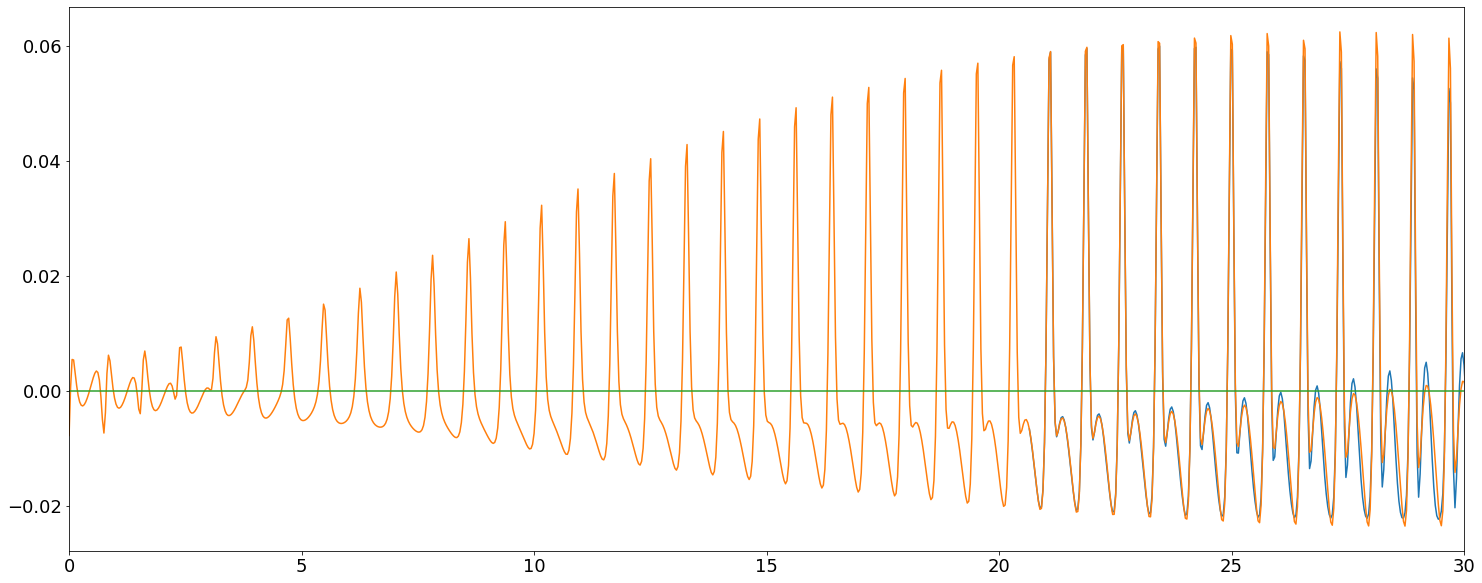

In [32]:
# plot the prediction and the baseline
plt.figure(figsize=(25, 10))
plt.plot(((pd.to_datetime(forecast['ds']) - pd.to_datetime(ts['ds'])[0]) /np.timedelta64(1, 'D')).astype(float),forecast['yhat'])
plt.plot(((pd.to_datetime(ts['ds']) - pd.to_datetime(ts['ds'])[0]) / np.timedelta64(1, 'D')).astype(float),ts['y'])
plt.plot(((pd.to_datetime(ts['ds']) - pd.to_datetime(ts['ds'])[0]) / np.timedelta64(1, 'D')).astype(float),[0]*(len(ts)))

plt.xlim([0,30])
# plt.ylim([-0.05,0.05])